In [48]:
import numpy as np
import pandas as pd
import altair as alt
import string
import nltk
from nltk.stem import SnowballStemmer, LancasterStemmer
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from textblob import TextBlob
from sentence_transformers import SentenceTransformer
import umap
import hdbscan


alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()
%matplotlib inline

In [2]:
disney_df = pd.read_csv("../data/raw/DisneylandReviews.csv")
reviews = disney_df['Review_Text']

In [3]:
reviews  

0        If you've ever been to Disneyland anywhere you...
1        Its been a while since d last time we visit HK...
2        Thanks God it wasn   t too hot or too humid wh...
3        HK Disneyland is a great compact park. Unfortu...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited Disneyland ...
42653    My eleven year old daughter and myself went to...
42654    This hotel, part of the Disneyland Paris compl...
42655    I went to the Disneyparis resort, in 1996, wit...
Name: Review_Text, Length: 42656, dtype: object

In [4]:
def preprocess(text):
    text = text.lower()
    text = text.replace('hk', 'hongkong')
    text = text.replace('hong kong', 'hongkong')
    text = text.replace("n't", " not")
    text = text.replace('n   t', " not")
    text = text.replace('disneyparis', 'disney paris')
    return text

In [5]:
reviews = reviews.apply(lambda x: preprocess(x))
reviews

0        if you've ever been to disneyland anywhere you...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park. u...
4        the location is not in the city, took around 1...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel, part of the disneyland paris compl...
42655    i went to the disney paris resort, in 1996, wi...
Name: Review_Text, Length: 42656, dtype: object

In [6]:
def remove_punc(text):
    clean = ''.join([char for char in text if char not in string.punctuation])
    return clean

In [7]:
reviews = reviews.apply(lambda x: remove_punc(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around 1 ...
                               ...                        
42651    i went to disneyland paris in july 03 and thou...
42652    2 adults and 1 child of 11 visited disneyland ...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in 1996 with...
Name: Review_Text, Length: 42656, dtype: object

In [8]:
def remove_digit(text):
    clean = ''.join([i for i in text if not i.isdigit()])
    return clean

In [9]:
reviews = reviews.apply(lambda x: remove_digit(x))
reviews

0        if youve ever been to disneyland anywhere youl...
1        its been a while since d last time we visit ho...
2        thanks god it was not too hot or too humid whe...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around  h...
                               ...                        
42651    i went to disneyland paris in july  and though...
42652     adults and  child of  visited disneyland pari...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in  with a s...
Name: Review_Text, Length: 42656, dtype: object

In [10]:
# def spell_checker(text):
#     t = TextBlob(text)
#     spell_checked = ' '.join([w.correct() for w in t.words])
#     return spell_checked 

In [11]:
# spell_checked = reviews.apply(lambda x: spell_checker(x))
# spell_checked 

In [12]:
def text_lemmatizer(text):
    t = TextBlob(text)
    lemmatized_text = ' '.join([w.lemmatize() for w in t.words])
    return lemmatized_text

In [13]:
reviews_lemmatized = reviews.apply(lambda x: text_lemmatizer(x))
reviews_lemmatized

0        if youve ever been to disneyland anywhere youl...
1        it been a while since d last time we visit hon...
2        thanks god it wa not too hot or too humid when...
3        hongkong disneyland is a great compact park un...
4        the location is not in the city took around ho...
                               ...                        
42651    i went to disneyland paris in july and thought...
42652    adult and child of visited disneyland paris be...
42653    my eleven year old daughter and myself went to...
42654    this hotel part of the disneyland paris comple...
42655    i went to the disney paris resort in with a sm...
Name: Review_Text, Length: 42656, dtype: object

In [14]:
tokenizer = RegexpTokenizer(r'\w+')

In [15]:
reviews_tokenized = reviews.apply(lambda x: tokenizer.tokenize(x.lower()))
reviews_tokenized 

0        [if, youve, ever, been, to, disneyland, anywhe...
1        [its, been, a, while, since, d, last, time, we...
2        [thanks, god, it, was, not, too, hot, or, too,...
3        [hongkong, disneyland, is, a, great, compact, ...
4        [the, location, is, not, in, the, city, took, ...
                               ...                        
42651    [i, went, to, disneyland, paris, in, july, and...
42652    [adults, and, child, of, visited, disneyland, ...
42653    [my, eleven, year, old, daughter, and, myself,...
42654    [this, hotel, part, of, the, disneyland, paris...
42655    [i, went, to, the, disney, paris, resort, in, ...
Name: Review_Text, Length: 42656, dtype: object

In [16]:
nltk_stopwords = pd.Series(stopwords.words("english"))
nltk_stopwords = nltk_stopwords.apply(lambda x: remove_punc(x))
nltk_stopwords = set(nltk_stopwords)

In [17]:
stopwords_700 = pd.read_csv('../EDA/stopwords.txt', header= None, delimiter = "\t")
stopwords_700 = set(stopwords_700[0])

In [18]:
def remove_stopwords(text): 
    stop_words = set(stopwords.words("english"))
    stop_words_customize = {'disney', 'disneyland', 'land', 'park', 'parks', 'world', 'disneyworld', 'disney world', 'one'}
    stop_words_all = nltk_stopwords.union(stopwords_700, stop_words_customize)
    clean = [word for word in text if not word in stop_words_all]
    return clean

In [19]:
reviews_nostop = reviews_tokenized.apply(lambda x: remove_stopwords(x))

In [20]:
reviews_nostop

0        [find, hongkong, similar, layout, walk, street...
1        [last, time, visit, hongkong, time, stay, tomo...
2        [thanks, god, hot, humid, visiting, big, issue...
3        [hongkong, great, compact, unfortunately, bit,...
4        [location, city, took, hour, kowlon, kids, lik...
                               ...                        
42651    [went, paris, july, thought, brilliant, visite...
42652    [adults, child, visited, paris, beginning, feb...
42653    [eleven, year, old, daughter, went, visit, son...
42654    [hotel, part, paris, complex, wonderful, place...
42655    [went, paris, resort, small, child, minute, en...
Name: Review_Text, Length: 42656, dtype: object

In [52]:
stemmer = LancasterStemmer()

def text_stemmer(text):
    stem_text = ' '.join([stemmer.stem(i) for i in text])
    return stem_text

In [53]:
a = "went"

In [54]:
stemmer.stem(a)

'went'

In [22]:
reviews_clean = reviews_nostop.apply(lambda x: text_stemmer(x))
reviews_clean

0        findhongkongsimilarlayoutwalkstreetfamiliarfee...
1        lasttimevisithongkongtimestaytomorrowlandakama...
2        thankgodhothumidvisitbigissushadeiarrivleftpmu...
3        hongkonggreatcompactunfortunbitmaintenworkgopr...
4        locatcititookhourkowlonkidlikefinecrowdhothong...
                               ...                        
42651    wentparijulithoughtbrilliantvisithotelstaynewp...
42652    adultchildvisitparibeginfebabsolutfantasttimew...
42653    elevenyearolddaughterwentvisitsonlondondecidpa...
42654    hotelpartparicomplexwonderplacefamilikidneedro...
42655    wentpariresortsmallchildminutentertransportpar...
Name: Review_Text, Length: 42656, dtype: object

In [23]:
reviews_clean[0:100]

0     findhongkongsimilarlayoutwalkstreetfamiliarfee...
1     lasttimevisithongkongtimestaytomorrowlandakama...
2     thankgodhothumidvisitbigissushadeiarrivleftpmu...
3     hongkonggreatcompactunfortunbitmaintenworkgopr...
4     locatcititookhourkowlonkidlikefinecrowdhothong...
                            ...                        
95    fantastniceplacekidfriendeaslifoodareabuyticke...
96    loveattractwellrunwellworthvisitfundayageeasil...
97    friendstaffcoolweatherklookpurchasdiscounttick...
98    smallestspentdaytokyofebruaricomparhongkongsay...
99    imbigfanregularvisitorpariexcitvisitnewgreatti...
Name: Review_Text, Length: 100, dtype: object

### embeddings

In [24]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(reviews_clean[0:10000], show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [25]:
embeddings

array([[-0.6940529 ,  0.28018403,  0.27974668, ..., -0.26895788,
        -0.34182492,  0.00938005],
       [-0.6940529 ,  0.28018403,  0.27974668, ..., -0.26895788,
        -0.34182492,  0.00938005],
       [-0.6940529 ,  0.28018403,  0.27974668, ..., -0.26895788,
        -0.34182492,  0.00938005],
       ...,
       [-0.6940529 ,  0.28018403,  0.27974668, ..., -0.26895788,
        -0.34182492,  0.00938005],
       [-0.6940529 ,  0.28018403,  0.27974668, ..., -0.26895788,
        -0.34182492,  0.00938005],
       [-0.6274111 ,  0.30988976,  0.669431  , ..., -0.7942135 ,
         0.5636187 , -0.05673214]], dtype=float32)

In [26]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [27]:
umap_embeddings

array([[16.196234  ,  8.651774  ,  7.470948  ,  0.40131304,  0.5727857 ],
       [16.447163  ,  8.852206  ,  6.500172  ,  1.8495114 ,  1.5170298 ],
       [16.129686  ,  7.6156077 ,  5.8947177 ,  1.3133422 , -0.14631887],
       ...,
       [16.208475  ,  8.894546  ,  6.7553782 ,  0.49448356,  0.38313153],
       [15.894567  ,  8.499065  ,  5.5301743 ,  1.9644712 ,  1.0229781 ],
       [-2.8229477 ,  8.117989  , 10.687864  ,  2.1290686 ,  1.6479046 ]],
      dtype=float32)

In [28]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [29]:
cluster

HDBSCAN(min_cluster_size=15)

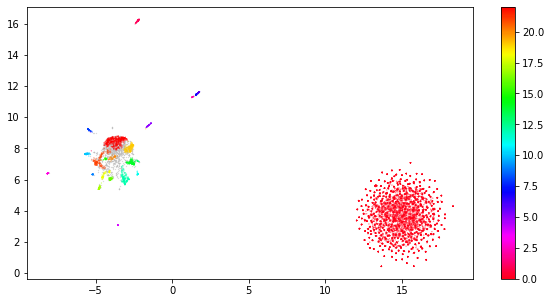

In [30]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()